In [ ]:
!python --version

Python 3.10.12


In [ ]:
# From Google Colab
!git clone https://github.com/jesusBV20/multi_C3BF.git
!rsync -a multi_C3BF/ .
!rm -r multi_C3BF

Cloning into 'multi_C3BF'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 46 (delta 14), reused 38 (delta 10), pack-reused 0
Unpacking objects: 100% (46/46), 8.52 MiB | 6.55 MiB/s, done.


In [ ]:
# ----------------------------------------------------------------------
# Importamos las librerías principales
# ----------------------------------------------------------------------

import os
import numpy as np
import warnings

# Para graficar
import matplotlib.pyplot as plt
from seaborn import color_palette

# Para animar y visualizar animaciones
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.patches as patches

# QP solvers
#!pip install qpsolvers
#from qpsolvers import solve_qp

# ----------------------------------------------------------------------
# CBF_tools
# ----------------------------------------------------------------------

# Toolbox
from CBF_tools.toolbox import unicycle_patch, fmt_data_axis, cone_params, createDir

# GVF trajectories
from CBF_tools.gvf_traj_ellipse  import gvf_ellipse, draw

# GVF + CBF simulator
from CBF_tools.simulator import simulator

# ----------------------------------------------------------------------
# Variables globales
# ----------------------------------------------------------------------
FOLDER_OUTPUT = "output"

# Paletas de colores suaves (https://g.co/kgs/4A3q4T)
cake_b = "#d9daff"
cake_r = "#ffdbd9"
cake_y = "#fffbd9"
cake_g = "#dcffd9"

# ----------------------------------------------------------------------
# Init
# ----------------------------------------------------------------------
createDir(FOLDER_OUTPUT)

¡Directorio 'output' creado!


# Simulaciones

## PLOT: Simulación GVF sencilla

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 25

# Constantes de los controladores
ke = 4
kn = 2

r = 10
gamma = 2

# Estado inicial de los agentes y número de agentes
n_agents = 2
p0 = np.array([[2, 2], [2, 8]])
v0 =  np.array([[0.8,0.9]]).T
phi0 = np.pi - np.array([-3*np.pi/4, -np.pi])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Realizamos toda la simulación mumerica
xdata, ydata = [], []
phidata = []

while sim.t < t_sim_final:
  xdata.append(sim.pf[:,0])
  ydata.append(sim.pf[:,1])
  phidata.append(sim.phif)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

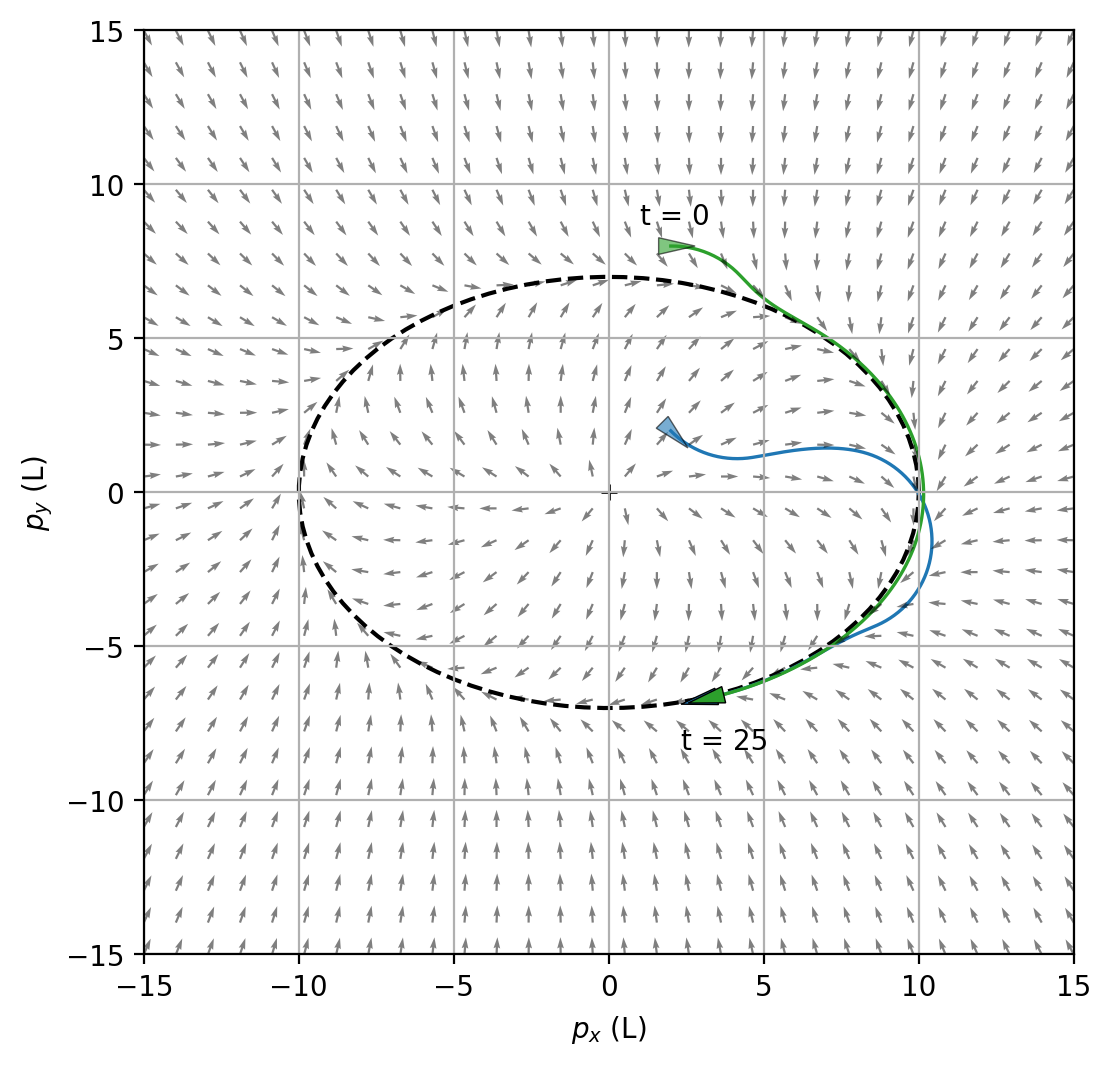

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(6, 6), dpi=200)
grid = plt.GridSpec(1, 1)
main_ax = fig.add_subplot(grid[:,:])

# Axis configuration
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

# Main axis
draw(gvf_traj, fig, main_ax)


li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n*2]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon.set_label("n"+str(n))

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

plt.text(xdata[0,1]-1, ydata[0,1]+0.7, "t = {0:.0f}".format(0))
plt.text(xdata[li,1]-1, ydata[li,1]-1.7, "t = {0:.0f}".format(t_sim_final))

plt.savefig(os.path.join(FOLDER_OUTPUT, 'GVF_CBF_intro1.png'))
plt.show()

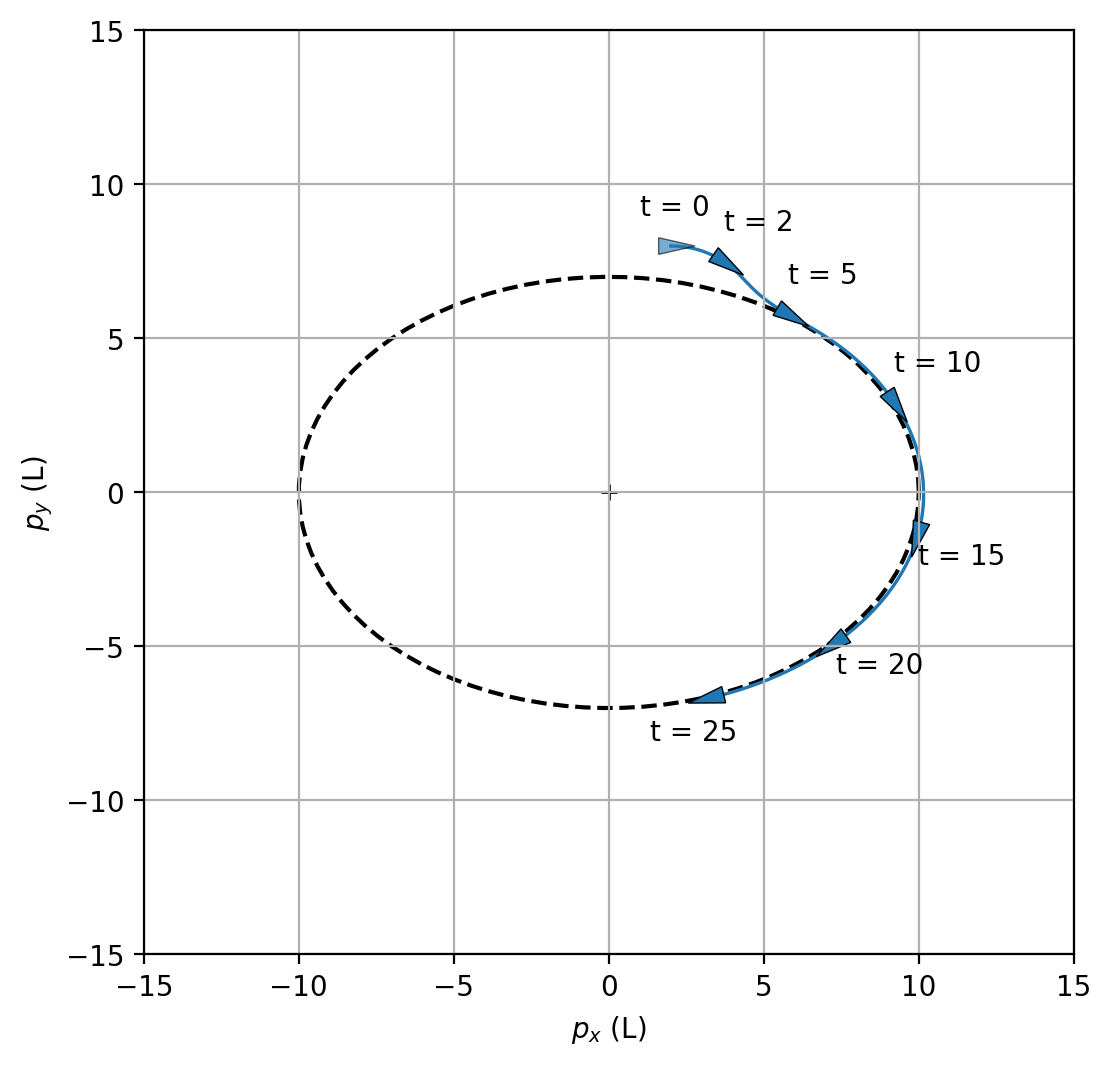

In [ ]:
# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(6, 6), dpi=200)
grid = plt.GridSpec(1, 1)
main_ax = fig.add_subplot(grid[:,:])

# Axis configuration
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

# Main axis
draw(gvf_traj, fig, main_ax, draw_field=False)

li = xdata.shape[0] - 1
n = 1

color = color_palette()[0]
icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
icon_init.set_alpha(0.6)
icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)

main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
main_ax.add_patch(icon_init)
main_ax.add_patch(icon)

# Inicio y final
plt.text(xdata[0,n]-1, ydata[0,n]+1, "t = {0:.0f}".format(0))
plt.text(xdata[li,n]-2, ydata[li,n]-1.4, "t = {0:.0f}".format(t_sim_final))

# Waypoints
t_list = [2,5,10,15,20]

for t in t_list:
  li = int(t/dt)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  main_ax.add_patch(icon)
  if ydata[li,n] > 0:
    plt.text(xdata[li,n], ydata[li,n]+1, "t = {0:.0f}".format(t))
  else:
    plt.text(xdata[li,n], ydata[li,n]-1, "t = {0:.0f}".format(t))

plt.savefig(os.path.join(FOLDER_OUTPUT, 'GVF_CBF_intro2.png'))
plt.show()

## PLOT: Notación y gráficos ilustrativos

In [ ]:
# ----------------------------
# C3BF - Gráficos de notación
# ----------------------------

# Parámetros
col_rad = 1

rbt_xy = np.array([ 0, 0])
obs_xy = np.array([-4, 0])
rbt_phi = -np.pi/1.03
obs_phi = np.pi
# ----------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (12, 6), dpi = 100)
ax = fig.subplots()

ax.set_xlim([-7,5])
ax.set_ylim([-3,3])
ax.set_xlabel(r"$p_x$ [L]")
ax.set_ylabel(r"$p_y$ [L]")
ax.grid(True)

# Dibujamos el robot
icon_rbt = unicycle_patch(rbt_xy, rbt_phi, "royalblue")
icon_rbt.set_alpha(0.8)
icon_rbt.set_label("Robot")
ax.add_patch(icon_rbt)

# Dibujamos el obstáculo
icon_obs = unicycle_patch(obs_xy, obs_phi, "yellowgreen")
icon_col = patches.Circle(obs_xy, col_rad, alpha=0.7, fill=False,
                          color="k", ls="--", lw=2)
ax.add_patch(icon_obs)
ax.add_patch(icon_col)

# Dibujamos el cono
P, K = cone_params(obs_xy, col_rad, rbt_xy)
I, H = cone_params(-obs_xy, col_rad, rbt_xy)

cone = patches.Polygon(np.array([rbt_xy, H, I]), alpha=0.2,
                       color="red", zorder=1, lw=0)
ax.add_patch(cone)

# Dibujamos puntos
pts = np.array([[0,0],H,I,P,K])
ax.plot(pts[:,0], pts[:,1], ".k", zorder=3)
ax.plot(obs_xy[0], obs_xy[1], ".", c="forestgreen", zorder=4)

# Dibujamos rectas
x_draw  = np.linspace(-5,4,100)
x_draw2 = np.linspace(-4,0,100)

ax.plot(x_draw, (K[1]-H[1])/(K[0]-H[0])*x_draw, "-k", lw=1, alpha=0.6)
ax.plot(x_draw, (P[1]-I[1])/(P[0]-I[0])*x_draw, "-k", lw=1, alpha=0.6)
ax.plot( x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)
ax.plot(-x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)

# Dibujamos vectores
arr_kw = {"width":0.003, "scale":10, "zorder":2}

v_rel_x = (np.cos(obs_phi) - 3*np.cos(rbt_phi))/2
v_rel_y = (np.sin(obs_phi) - 3*np.sin(rbt_phi))/2
ax.quiver(rbt_xy[0], rbt_xy[1], v_rel_x, v_rel_y, color="red", **arr_kw)
ax.quiver(rbt_xy[0], rbt_xy[1], np.cos(rbt_phi), np.sin(rbt_phi), color="k", **arr_kw)
ax.quiver(obs_xy[0], obs_xy[1], np.cos(obs_phi)/3, np.sin(obs_phi)/3, color="k", **arr_kw)

# Dibujamos arcos
r = 2.5
x_arc1 = np.linspace(-r, -r*np.cos(np.pi/12.5), 100)
x_arc2 = np.linspace(r*np.cos(np.pi/12.5), r , 100)

ax.plot(x_arc1,  np.sqrt(r**2 - x_arc1**2), "-k", lw=0.8)
ax.plot(x_arc2, -np.sqrt(r**2 - x_arc2**2), "-k", lw=0.8)

# Dibujamos los textos
ax.text(2.6,-0.4, r"$\phi$",  fontsize=12)
ax.text(-0.29,-0.5, r"$(x,y)$", fontsize=12)
ax.text(-4.4,-0.5, r"$(c_x,c_y)$", fontsize=12)

ax.text(-0.1,0.2, "E", fontsize=16, fontfamily="serif")
ax.text(I[0]-0.1, I[1]-0.4, "I",  fontsize=16, fontfamily="serif")
ax.text(H[0]-0.1, H[1]+0.2, "H",  fontsize=16, fontfamily="serif")
ax.text(K[0]-0.1, K[1]-0.4, "K",  fontsize=16, fontfamily="serif")
ax.text(P[0]-0.1, P[1]+0.2, "P",  fontsize=16, fontfamily="serif")

ax.text(1.3, 0.17, r"$v_{rel}$", c="red", fontsize=12)
ax.text(-1.7, -0.2, r"$v_{rbt}$", fontsize=12)
ax.text(-4.8, 0.15, r"$v_{obs}$", fontsize=12)
ax.text(-4.4,-0.5, r"$(c_x,c_y)$", fontsize=12)

# Legenda
icon_obs.set_label("Obstáculo real")
icon_col.set_label("Obstáculo virtual")
cone.set_label("Cono de colisión")
plt.legend(loc="upper left", ncol=2, fancybox=True, framealpha=1)

# Guardamos y dibujamos la figura
plt.savefig(os.path.join(FOLDER_OUTPUT, 'C3BF_0.png'))
plt.show()

<IPython.core.display.Javascript object>

## PLOT: C3BF - Visualización del cono

### Simulación numérica

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 40

# Constantes de los controladores
ke = 4
kn = 2

r = 1
gamma = 2

# Estado inicial de los agentes y número de agentes
n_agents = 2
p0 = np.array([[2, 8], [0, -7]])
v0 =  np.array([[0.9, 0.0]]).T
phi0 = np.pi - np.array([np.pi, 0])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Realizamos toda la simulación mumerica
xdata, ydata = [], []
phidata = []
hdata = []
psi_data = []
kappa_data = []
vreldata = []

for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    hdata.append(sim.h)
    psi_data.append(sim.psi)
    kappa_data.append(sim.kappa)
    vreldata.append(sim.v_rel)
  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

hdata = np.array(hdata)
psi_data = np.array(psi_data)
kappa_data = np.array(kappa_data)
vreldata = np.array(vreldata)

### Grafiquitos chulos

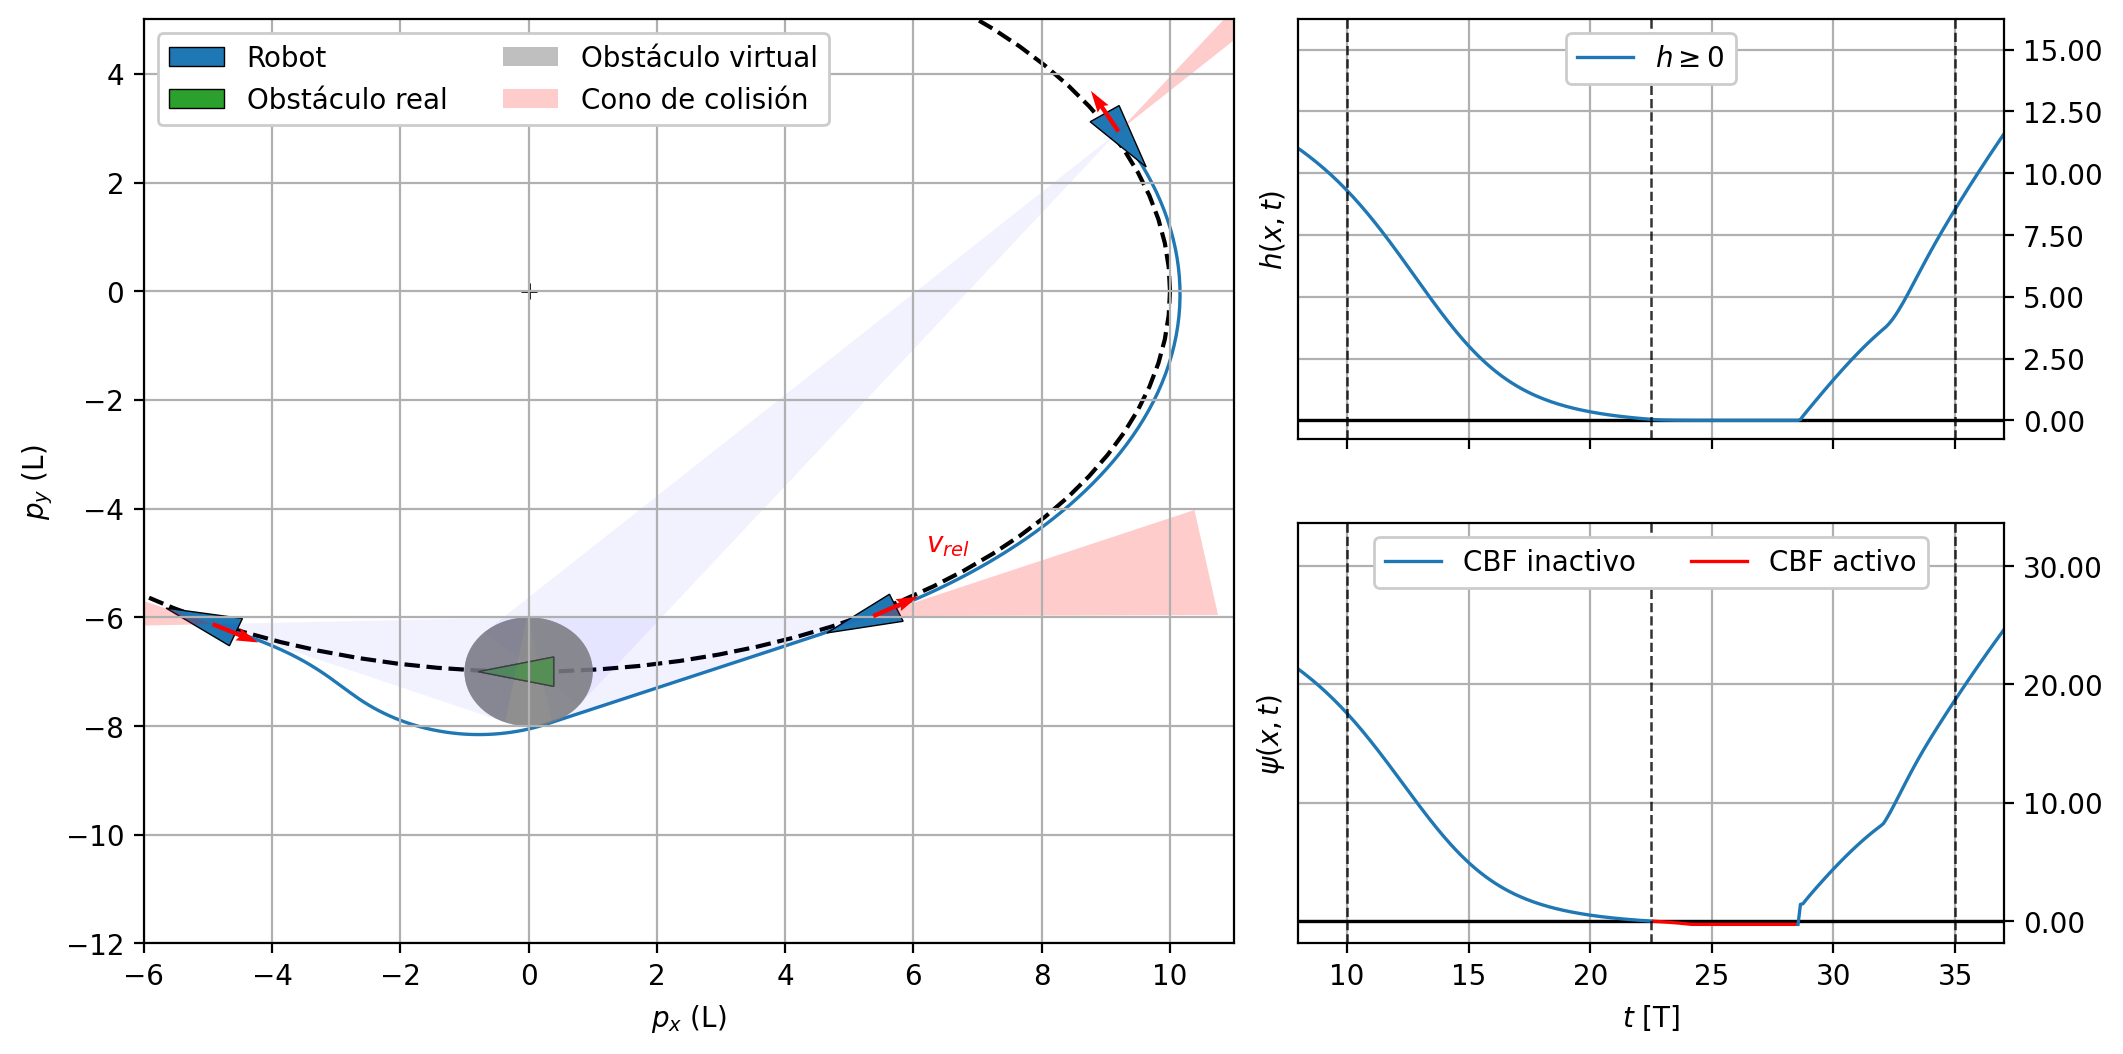

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# -- Preliminares --
n_rbt = 0
n_obs = 1
color_rbt = color_palette()[0]
color_obs = color_palette()[2]
t_list = np.array([10,22.5,35])

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

# Inicializamos las figuras y el grid
fig = plt.figure(figsize=(12, 6), dpi=200)
grid = plt.GridSpec(2, 5, hspace=0.2, wspace=0.2)
main_ax    = fig.add_subplot(grid[:,0:3])
hdata_ax   = fig.add_subplot(grid[0,3:5], xticklabels=[])
psidata_ax = fig.add_subplot(grid[1,3:5])

# Configuramos los ejes
main_ax.set_xlim([-6,11])
main_ax.set_ylim([-12,5])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True, zorder=0)

fmt_data_axis(hdata_ax, r"$h(x,t)$",
              xlim=[t_list[0]-2,t_list[-1]+2])
fmt_data_axis(psidata_ax, r"$\psi(x,t)$", r"$t$ [T]",
              xlim=[t_list[0]-2,t_list[-1]+2])

# ---------------------------------------------------
# Main axis

draw(gvf_traj, fig, main_ax, draw_field=False)

# -- Dibujamos los patches
for t in t_list:
  li = int(t/dt)-1
  rbt_xy = np.array([xdata[li,n_rbt], ydata[li,n_rbt]])
  obs_xy = np.array([xdata[li,n_obs], ydata[li,n_obs]])
  p_rel = obs_xy - rbt_xy
  v_rel = vreldata[li,1,0,:] / 2

  # Dibujamos el robot
  icon_rbt = unicycle_patch([xdata[li,n_rbt], ydata[li,n_rbt]],
                            phidata[li,n_rbt], color_rbt)
  icon_obs = unicycle_patch([xdata[li,n_obs], ydata[li,n_obs]],
                            phidata[li,n_obs], color_obs)
  #icon_rbt.set_alpha(0.6)
  main_ax.add_patch(icon_rbt)
  main_ax.add_patch(icon_obs)

  # Región de colisión vitual
  icon_col = patches.Circle(obs_xy, r, alpha=0.5, fill=True,
                            color="gray", ls="-", lw=0)
  main_ax.add_patch(icon_col)

  # Dibujamos el CONO AZUL
  p1, p2 = cone_params(obs_xy, r, rbt_xy)
  cone1 = patches.Polygon(np.array([rbt_xy, p1, p2]),
                        alpha=0.05, color="blue", zorder=1, lw=0)
  main_ax.add_patch(cone1)

  # Dibujamos el CONO ROJO
  p1, p2 = cone_params(obs_xy - 2*p_rel, r, rbt_xy)
  cone2 = patches.Polygon(np.array([rbt_xy, p1, p2]),
                        alpha=0.2, color="red", zorder=1, lw=0)
  main_ax.add_patch(cone2)

  # Dibujamos vector V_REL
  arr_kw = {"color":"red", "width":0.004, "scale":10, "zorder":2}
  #main_ax.quiver(rbt_xy[0], rbt_xy[1], v_rel[0,li,n_rbt], v_rel[1,li,n_rbt], **arr_kw)
  main_ax.quiver(rbt_xy[0], rbt_xy[1], v_rel[0], v_rel[1], **arr_kw)

  # Etiquetas
  if t == t_list[0]:
    icon_rbt.set_label("Robot")
    icon_obs.set_label("Obstáculo real")
    icon_col.set_label("Obstáculo virtual")
    cone2.set_label("Cono de colisión")

# -- Dibujamos la traza
li, lf = int(t_list[0]/dt)-1, int(t_list[-1]/dt)-1
main_ax.plot(xdata[li:lf,n_rbt],ydata[li:lf,n_rbt], c=color_rbt,
             ls="-", lw=1.2, zorder=0)

# -- Texto
main_ax.text(6.2, -4.8, r"$v_{rel}$", c="red")


# ---------------------------------------------------
# Data axis

time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
hdata_ax.axhline(0, c="k", ls="-", lw=1.2, zorder=2)
psidata_ax.axhline(0, c="k", ls="-", lw=1.2, zorder=2)

# Plotting data
mask_active = psi_data[:,1,0] < 0

l1 = np.where(mask_active)[0][0]
l2 = np.where(mask_active)[0][-1]

psidata_ax.plot(time_vec[0:l1], psi_data[0:l1,1,0], c=color_rbt, lw=1.2,
                label="CBF inactivo")
psidata_ax.plot(time_vec[l1:l2], psi_data[l1:l2,1,0], c="red", lw=1.2,
                label="CBF activo")
psidata_ax.plot(time_vec[l2:], psi_data[l2:,1,0], c=color_rbt, lw=1.2)

hdata_ax.plot(time_vec, hdata[:,1,0], c=color_rbt, lw=1.2, label=r"$h \geq 0$")

# Vertical lines
for t in t_list:
  hdata_ax.axvline(t, c="k", ls="--", lw=0.9, zorder=2, alpha=0.8)
  psidata_ax.axvline(t, c="k", ls="--", lw=0.9, zorder=2, alpha=0.8)

# ---------------------------------------------------
# Visualizamos y guardamos
main_ax.legend(loc="upper left", ncol=2, fancybox=True, framealpha=1)
hdata_ax.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1)
psidata_ax.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1)

plt.savefig(os.path.join(FOLDER_OUTPUT, 'C3BF_1.png'))
plt.show()

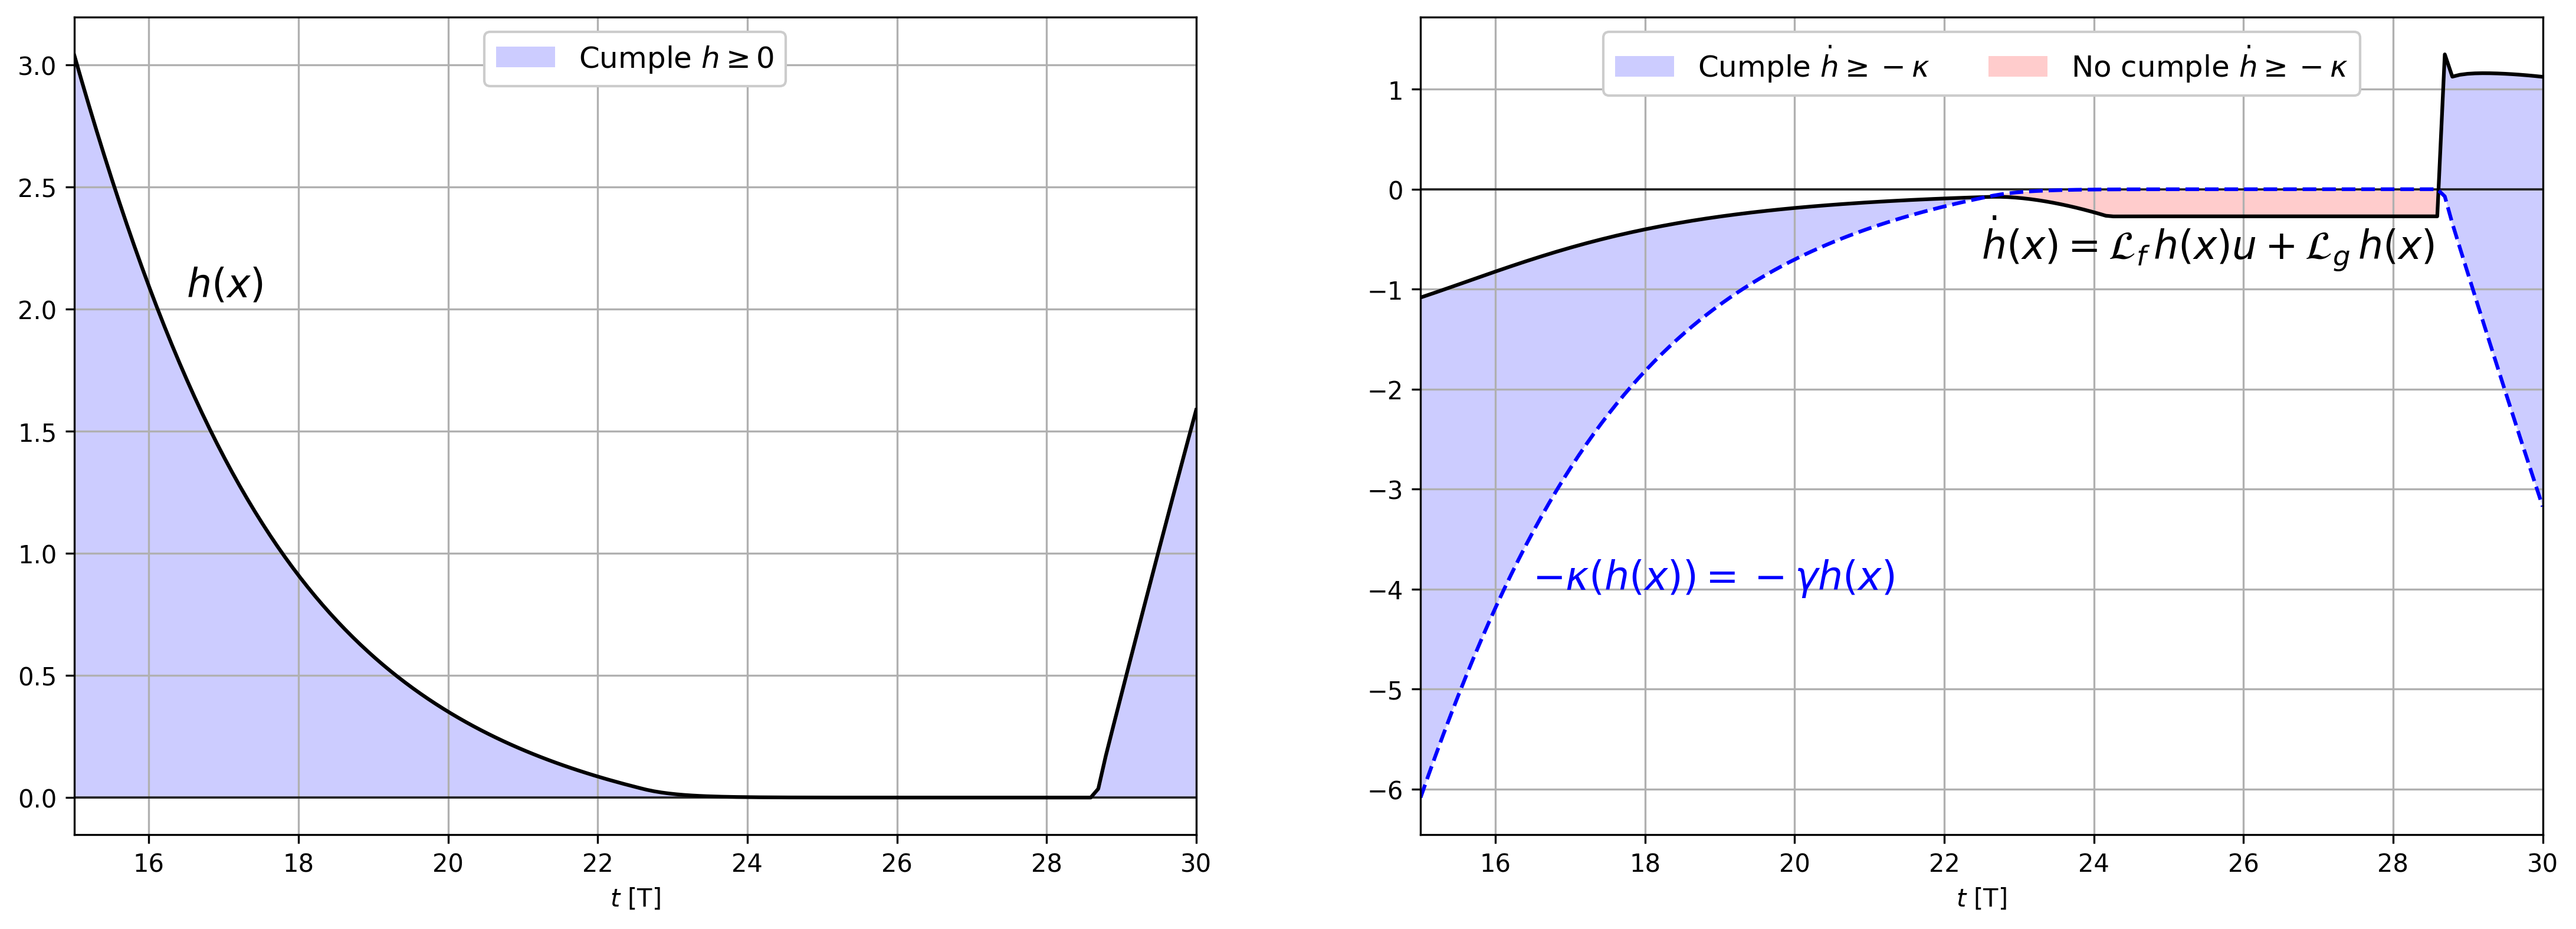

In [ ]:
# -----------------------------
# CBF - Gráficos ilustrativos
# -----------------------------

# Preliminares
t1, t2 = 15, 30
li, lf = int(t1/dt-1), int(t2/dt-1)

# Rango de evaluación en x
x_eval = np.linspace(t1, t2, int((t2-t1)/dt))
h_eval = hdata[li:lf,1,0]
kappa_eval = -kappa_data[li:lf,1,0]
h_dot_eval = psi_data[li:lf,1,0] + kappa_eval

# --------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (18, 6), dpi = 300)
grid = plt.GridSpec(1, 2, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(grid[:,0])
ax2 = fig.add_subplot(grid[:,1])

# Configuración de los ejes
ax1.set_xlim([t1,t2])
ax1.set_xlabel(r"$t$ [T]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax2.set_xlim([t1,t2])
ax2.set_xlabel(r"$t$ [T]")
ax2.set_ylabel(r"")
ax2.grid(True)

# Graficamos
ax1.axhline(0, c="k", ls="-", lw=0.9, zorder=2, alpha=0.8)
ax1.plot(x_eval, h_eval, "k")

ax2.axhline(0, c="k", ls="-", lw=0.9, zorder=2, alpha=0.8)
ax2.plot(x_eval, h_dot_eval, "-k")
ax2.plot(x_eval, kappa_eval, "--b")

# Dibujamos el área
mask_active = h_dot_eval < kappa_eval

l1 = np.where(mask_active)[0][0]
l2 = np.where(mask_active)[0][-1]

area_pts0 = np.c_[np.array([x_eval, h_eval]),
                  np.array([np.flip(x_eval), 0*x_eval])].T
area_pts1 = np.c_[np.array([x_eval[:l1], h_dot_eval[:l1]]),
                  np.array([np.flip(x_eval[:l1]),
                            np.flip(kappa_eval[:l1])])].T
area_pts2 = np.c_[np.array([x_eval[l1:l2+1], h_dot_eval[l1:l2+1]]),
                  np.array([np.flip(x_eval[l1:l2+1]),
                            np.flip(kappa_eval[l1:l2+1])])].T
area_pts3 = np.c_[np.array([x_eval[l2:], h_dot_eval[l2:]]),
                  np.array([np.flip(x_eval[l2:]),
                            np.flip(kappa_eval[l2:])])].T

area0 = patches.Polygon(area_pts0, alpha=0.2, color="blue", zorder=1, lw=0,
                        label="Cumple $h \geq 0$")
area1 = patches.Polygon(area_pts1, alpha=0.2, color="blue", zorder=1, lw=0,
                        label="Cumple $\dot h \geq -\kappa$")
area2 = patches.Polygon(area_pts2, alpha=0.2, color="red", zorder=1, lw=0,
                        label="No cumple $\dot h \geq -\kappa$")
area3 = patches.Polygon(area_pts3, alpha=0.2, color="blue", zorder=1, lw=0)

ax1.add_patch(area0)
ax2.add_patch(area1)
ax2.add_patch(area2)
ax2.add_patch(area3)

# Texto
ax1.text(16.5, 2.05, r"$h(x)$", fontsize=16, c="k")

ax2.text(22.5, -0.7, r"$\dot h(x) = \mathcal{L}_f\,h(x)u + \mathcal{L}_g\,h(x)$",
         fontsize=16, c="k")
ax2.text(16.5, -4, r"$- \kappa(h(x)) = - \gamma h(x)$",
         fontsize=16, c="b")

# Guardamos la figura y visualizamos
ax1.legend(loc="upper center", ncol=1, fancybox=True, framealpha=1, fontsize=12)
ax2.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1, fontsize=12)

plt.savefig(os.path.join(FOLDER_OUTPUT, 'CBF_1.png'))
plt.show()

---
## PLOT: C3BF - Adelantamiento horario y antihorario

### Simulación numérica horaria

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj1 = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 25

# Constantes de los controladores
ke = 3
kn = 2

r = 1
gamma = 0.5

# Estado inicial de los agentes y número de agentes
n_agents = 3
p0 = np.array([[-2, 2], [2, 8], [3, -3]])
v01 =  np.array([[0.8,1.2,3.2]]).T
phi0 = np.pi - np.array([-np.pi/4, -3*np.pi/4, np.pi/4])

x0 = [t0, p0, v01, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj1, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj1.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []
preldata = []
vreldata = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)
    preldata.append(sim.p_rel)
    vreldata.append(sim.v_rel)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata1 = np.array(xdata)
ydata1 = np.array(ydata)
phidata1 = np.array(phidata)

preldata1 = np.array(preldata)
vreldata1 = np.array(vreldata)

sim1 = sim

### Simulación numérica antihoraria

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj2 = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = -1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 25

# Constantes de los controladores
ke = 3
kn = 2

r = 1
gamma = 0.2

# Estado inicial de los agentes y número de agentes
n_agents = 3
p0 = np.array([[10, 5], [-2, 2], [11, 2]])
v02 =  np.array([[0.4,1.2,2.3]]).T
phi0 = np.pi - np.array([0, -np.pi/4, np.pi/4])

x0 = [t0, p0, v02, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj2, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj2.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []
preldata = []
vreldata = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)
    preldata.append(sim.p_rel)
    vreldata.append(sim.v_rel)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata2 = np.array(xdata)
ydata2 = np.array(ydata)
phidata2 = np.array(phidata)

preldata2 = np.array(preldata)
vreldata2 = np.array(vreldata)

sim2 = sim

### Grafiquito

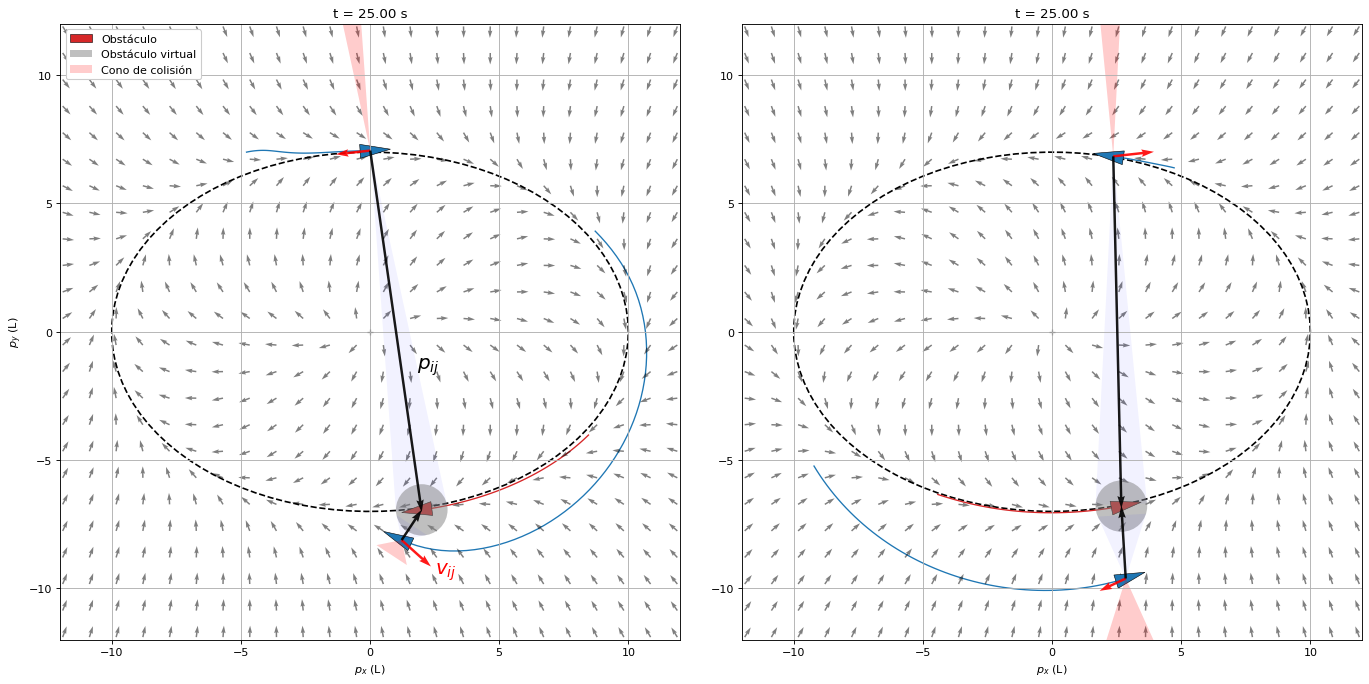

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(21, 10)
dpi=80

ti, tf = 10, 20
li, lf = int(ti/dt)-2, int(tf/dt)-2
tail = 60

color_plt = [color_palette()[0], color_palette()[3], color_palette()[0]]
arr_kw = {"width":0.004, "scale":24, "zorder":2, "alpha":0.9}

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(1, 2, hspace=0.4, wspace=0.1)

# Inicialización de los ejes
main_ax  = fig.add_subplot(grid[:,0])
main_ax2 = fig.add_subplot(grid[:,1])

# Se da formato a los ejes
main_ax.set_xlim([-12,12])
main_ax.set_ylim([-12,12])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

main_ax2.set_xlim([-12,12])
main_ax2.set_ylim([-12,12])
main_ax2.set_xlabel(r"$p_x$ (L)")
main_ax2.grid(True)

## Main axis 1 ----------------
draw(gvf_traj1, fig, main_ax)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))

for n in range(sim2.N):
  color = color_plt[n] # color

  # Final icon
  icon = unicycle_patch([xdata1[lf,n], ydata1[lf,n]], phidata1[lf,n], color)
  main_ax.add_patch(icon)

  # Traza
  main_ax.plot(xdata1[lf-tail:lf,n], ydata1[lf-tail:lf,n], c=color, ls="-", lw=1.2, zorder=0)

  if n == 1:
    # Zone de colisión vitual
    p_obs = [xdata1[lf,n], ydata1[lf,n]]
    icon_col = patches.Circle(p_obs, r, alpha=0.5, fill=True,
                              color="gray", ls="-", lw=0)
    main_ax.add_patch(icon_col)

    icon.set_label("Obstáculo")
    icon_col.set_label("Obstáculo virtual")

  if n == 0 or n == 2:
    p_obs, p_rbt = [xdata1[lf,1], ydata1[lf,1]], [xdata1[lf,n], ydata1[lf,n]]
    p_rel = np.array(p_obs) - np.array(p_rbt)

    # Dibujamos el CONO AZUL
    p1, p2 = cone_params(p_obs, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.05, color="blue", zorder=1, lw=0)
    main_ax.add_patch(cone)

    # Dibujamos el CONO ROJO
    p1, p2 = cone_params(p_obs - 2*p_rel, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.2, color="red", zorder=1, lw=0)
    main_ax.add_patch(cone)

    # Dibujamos flechas
    v_obs, v_rbt = v01[1], v01[n]
    phi_obs = phidata1[lf,1]
    phi_rbt = phidata1[lf,n]
    v_rel = (v_obs*np.array([np.cos(phi_obs), np.sin(phi_obs)]) - \
             v_rbt*np.array([np.cos(phi_rbt), np.sin(phi_rbt)]) )/1.5

    main_ax.quiver(p_rbt[0], p_rbt[1], v_rel[0], v_rel[1], **arr_kw, color="red")
    main_ax.quiver(p_rbt[0], p_rbt[1], p_rel[0], p_rel[1], **arr_kw, color="k")

    # Texto y leyenda
    if n == 0:
      main_ax.text(p_obs[0]-0.2, p_obs[1]+5.5, r"$p_{ij}$", c="k"  , fontsize=18)
      main_ax.text(p_obs[0]+0.5, p_obs[1]-2.5, r"$v_{ij}$", c="red", fontsize=18)
    if n == 2:
      cone.set_label("Cono de colisión")


## Main axis 2 ----------------
draw(gvf_traj2, fig, main_ax2)
main_ax2.set_title("t = {0:.2f} s".format(t_sim_final))

for n in range(sim2.N):
  color = color_plt[n] # color

  # Final icon
  icon = unicycle_patch([xdata2[lf,n], ydata2[lf,n]], phidata2[lf,n], color)
  icon.set_label("n"+str(n+1))
  main_ax2.add_patch(icon)

  # Traza
  main_ax2.plot(xdata2[lf-tail:lf,n], ydata2[lf-tail:lf,n], c=color, ls="-", lw=1.2, zorder=0)

  if n == 1:
    # Zone de colisión vitual
    p_obs = [xdata2[lf,n], ydata2[lf,n]]
    icon_col = patches.Circle(p_obs, r, alpha=0.5, fill=True,
                              color="gray", ls="-", lw=0)
    main_ax2.add_patch(icon_col)

  if n == 0 or n == 2:
    p_obs, p_rbt = [xdata2[lf,1], ydata2[lf,1]], [xdata2[lf,n], ydata2[lf,n]]
    p_rel = np.array(p_obs) - np.array(p_rbt)

    # Dibujamos el CONO AZUL
    p1, p2 = cone_params(p_obs, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.05, color="blue", zorder=1, lw=0)
    main_ax2.add_patch(cone)

    # Dibujamos el CONO ROJO
    p1, p2 = cone_params(p_obs - 2*p_rel, r, p_rbt)
    cone = patches.Polygon(np.array([p_rbt, p1, p2]),
                          alpha=0.2, color="red", zorder=1, lw=0)
    main_ax2.add_patch(cone)

    # Dibujamos flechas
    v_obs, v_rbt = v02[1], v02[n]
    phi_obs = phidata2[lf,1]
    phi_rbt = phidata2[lf,n]
    v_rel = (v_obs*np.array([np.cos(phi_obs), np.sin(phi_obs)]) - \
             v_rbt*np.array([np.cos(phi_rbt), np.sin(phi_rbt)]) )

    main_ax2.quiver(p_rbt[0], p_rbt[1], v_rel[0], v_rel[1], **arr_kw, color="red")
    main_ax2.quiver(p_rbt[0], p_rbt[1], p_rel[0], p_rel[1], **arr_kw, color="k")

# Visualización de la leyenda y el gráfico final
main_ax.legend(loc="upper left", ncol=1, fancybox=True, framealpha=1)

plt.savefig(os.path.join(FOLDER_OUTPUT, 'C3BF_cone.png'))
plt.show()

---
## PLOT: Simulación GVF + CBF adaptada al experimento

### Simulación numérica

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 35

# Constantes de los controladores
ke = 3
kn = 2

r = 2
gamma = 0.5

# Estado inicial de los agentes y número de agentes
n_agents = 3
p0 = np.array([[2, 8], [-2, 2], [3, -3]])
v0 =  np.array([[1.2,2.3,3.2]]).T
phi0 = np.pi - np.array([-3*np.pi/4, -np.pi/4, np.pi/4])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
omega_safe_data = []
edata = []
phidata = []
psi_data = []
preldata, vreldata = [], []
hdata, kappa_data = [], []
hdotdata = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)
    edata.append(sim.e)

    psi_data.append(sim.psi)
    omega_safe_data.append(sim.omega_safe)
    preldata.append(sim.p_rel)
    vreldata.append(sim.v_rel)
    hdata.append(sim.h)
    kappa_data.append(sim.kappa)
    hdotdata.append(sim.h_dot)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)
edata = np.array(edata)

omega_safe_data = np.array(omega_safe_data)
psi_data = np.array(psi_data)
preldata = np.array(preldata)
vreldata = np.array(vreldata)
hdata = np.array(hdata)
kappa_data = np.array(kappa_data)
hdotdata = np.array(hdotdata)

### Verificación visual de resultados

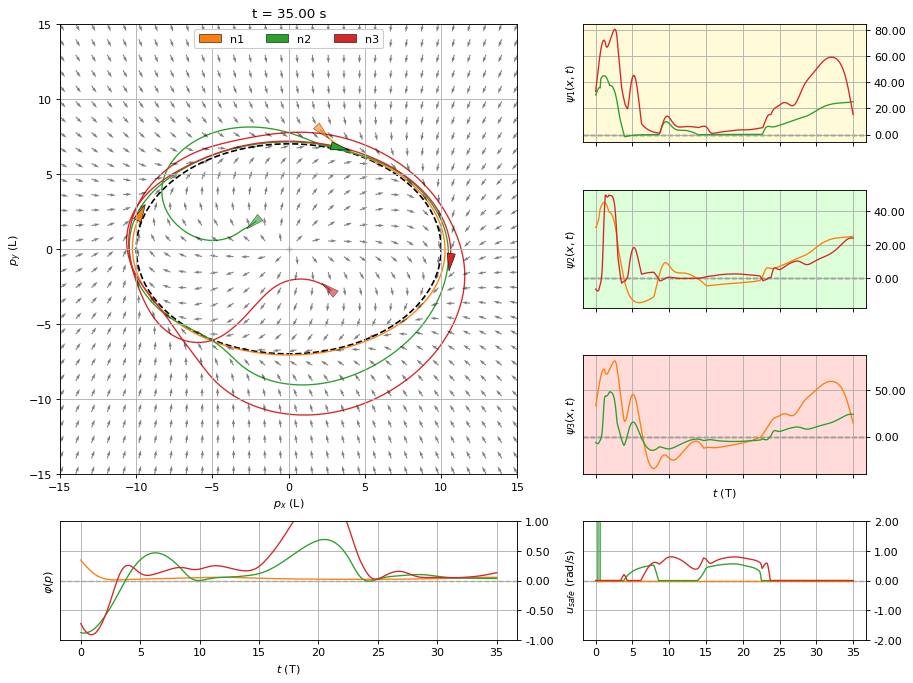

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(13, 10)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(4, 5, hspace=0.4, wspace=0.6)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[0:3, 0:3])
edata_ax     = fig.add_subplot(grid[3, 0:3])
wsafedata_ax = fig.add_subplot(grid[3, 3:5])


psi1_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
psi2_ax = fig.add_subplot(grid[1, 3:5], xticklabels=[])
psi3_ax = fig.add_subplot(grid[2, 3:5], xticklabels=[])
psi_axis = [psi1_ax, psi2_ax, psi3_ax]

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, r"$u_{safe}$ (rad/s)", ylim=[-2,2])
fmt_data_axis(edata_ax, r"$\varphi(p)$", r"$t$ (T)", ylim=[-1,1])

fmt_data_axis(psi1_ax, r"$\psi_1(x,t)$")
fmt_data_axis(psi2_ax, r"$\psi_2(x,t)$")
fmt_data_axis(psi3_ax, r"$\psi_3(x,t)$", r"$t$ (T)")

# Background color
psi1_ax.patch.set_facecolor(cake_y)
psi2_ax.patch.set_facecolor(cake_g)
psi3_ax.patch.set_facecolor(cake_r)

## Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n+1]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon.set_label("n"+str(n+1))

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)

## Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  color = color_palette()[n+1]
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], c=color, lw=1.2)
  edata_ax.plot(time_vec, edata[:,n], c=color, lw=1.2)
  for k in range(sim.N):
    if k != n:
      color = color_palette()[k+1]
      psi_axis[n].plot(time_vec, psi_data[:,k,n], c=color, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

plt.show()

In [ ]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail  = 250
figsize = (13, 10)
dpi     = 100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(4, 5, hspace=0.4, wspace=0.6)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[0:3, 0:3])
edata_ax     = fig.add_subplot(grid[3, 0:3])
wsafedata_ax = fig.add_subplot(grid[3, 3:5])

psi1_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
psi2_ax = fig.add_subplot(grid[1, 3:5], xticklabels=[])
psi3_ax = fig.add_subplot(grid[2, 3:5], xticklabels=[])
psi_axis = [psi1_ax, psi2_ax, psi3_ax]

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, r"$u_{safe}$ (rad/s)", ylim=[-2,2])
fmt_data_axis(edata_ax, r"$\varphi(p)$", r"$t$ (T)", ylim=[-1,1])

fmt_data_axis(psi1_ax, r"$\psi_1(x,t)$")
fmt_data_axis(psi2_ax, r"$\psi_2(x,t)$")
fmt_data_axis(psi3_ax, r"$\psi_3(x,t)$", r"$t$ (T)")

# Background color
psi1_ax.patch.set_facecolor(cake_y)
psi2_ax.patch.set_facecolor(cake_g)
psi3_ax.patch.set_facecolor(cake_r)

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()[1:]
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init.set_alpha(0.6)
  icon_init.set_label("n"+str(n+1))


  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[n],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title("")

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

data_lines_plt = []
psilines = []
for n in range(sim.N):
  kw = dict(c=c_palet[n], lw=1.2)
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], **kw)
  edata_ax.plot(time_vec, edata[:,n], **kw)
  for k in range(sim.N):
    if k != n:
      color = c_palet[k]
      psi_axis[n].plot(time_vec, psi_data[:,k,n], c=color, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
  psilines.append(psi_axis[n].axvline(0, c="black", ls="--", lw=1.2))

wline = wsafedata_ax.axvline(0, c="black", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="black", ls="--", lw=1.2)

# Plotting data
for n in range(sim.N):
  color = c_palet[n]
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], c=color, lw=1.2)
  edata_ax.plot(time_vec, edata[:,n], c=color, lw=1.2)
  for k in range(sim.N):
    if k != n:
      color = c_palet[k]
      psi_axis[n].plot(time_vec, psi_data[:,k,n], c=color, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[n])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])
    psilines[n].set_xdata(i*dt)

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  # Actualizamos el título
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s'.format(i, i*dt))

  wline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=20)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  3.40 | 9.77%
tf =  6.80 | 19.54%
tf = 10.20 | 29.31%
tf = 13.60 | 39.08%
tf = 17.00 | 48.85%
tf = 20.40 | 58.62%
tf = 23.80 | 68.39%
tf = 27.20 | 78.16%
tf = 30.60 | 87.93%
tf = 34.00 | 97.70%


### Figura para el TFM

TypeError: ignored

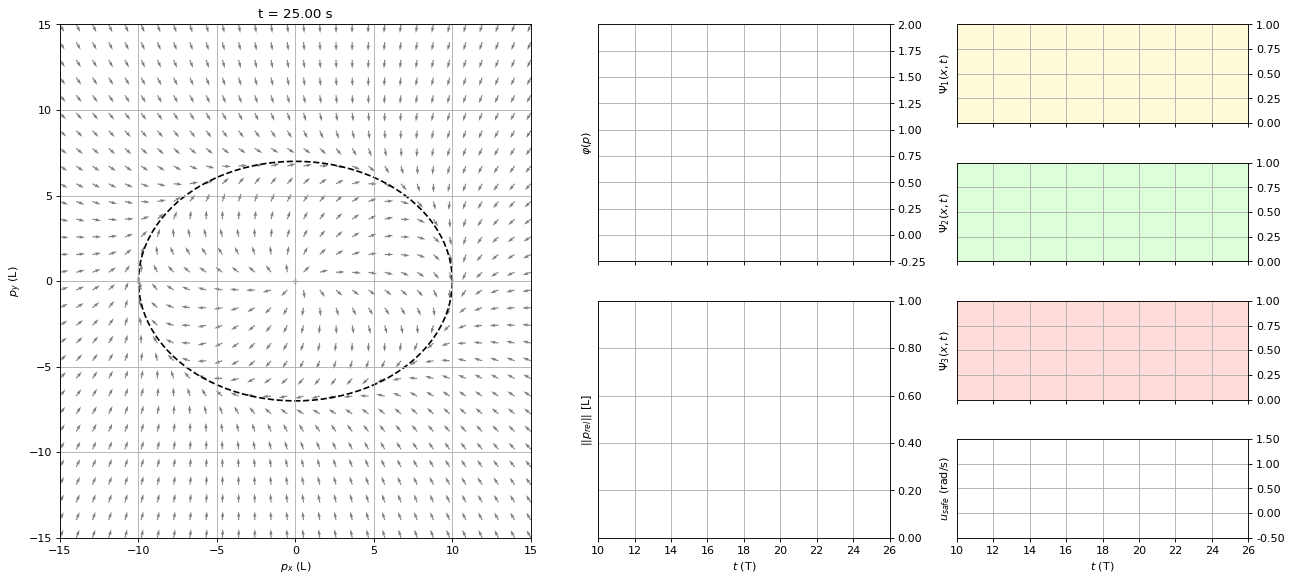

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

color_plt = [color_palette()[1], color_palette()[2], color_palette()[3]]
figsize=(23/1.2, 10/1.2)
dpi=80

# Tiempo inicial y final del gráfico
ti, tf = 10, 26
li, lf = int(ti/dt)-2, int(tf/dt)-2

# ---------------------------------------------
# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(4, 7, hspace=0.4, wspace=0.6)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[0:4, 0:3])
edata_ax     = fig.add_subplot(grid[0:2, 3:5], xticklabels=[])
preldata_ax  = fig.add_subplot(grid[2:4, 3:5])

psi1_ax = fig.add_subplot(grid[0, 5:7], xticklabels=[])
psi2_ax = fig.add_subplot(grid[1, 5:7], xticklabels=[])
psi3_ax = fig.add_subplot(grid[2, 5:7], xticklabels=[])
psi_axis = [psi1_ax, psi2_ax, psi3_ax]

wsafedata_ax = fig.add_subplot(grid[3, 5:7])

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(edata_ax, r"$\varphi(p)$", xlim=[ti,tf], ylim=[-0.25,2])
fmt_data_axis(preldata_ax, r"$||p_{rel}||$ [L]", r"$t$ (T)",
              xlim=[ti,tf])

fmt_data_axis(psi1_ax, r"$\Psi_1(x,t)$", xlim=[ti,tf])
fmt_data_axis(psi2_ax, r"$\Psi_2(x,t)$", xlim=[ti,tf])
fmt_data_axis(psi3_ax, r"$\Psi_3(x,t)$", xlim=[ti,tf])
fmt_data_axis(wsafedata_ax, r"$u_{safe}$ (rad/s)", r"$t$ (T)",
              xlim=[ti,tf], ylim=[-0.5,1.5])

# Background color
psi1_ax.patch.set_facecolor(cake_y)
psi2_ax.patch.set_facecolor(cake_g)
psi3_ax.patch.set_facecolor(cake_r)

# ---------------------------------------------
# Playground (main axis)
draw(gvf_traj, fig, main_ax)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))

for n in range(sim.N):
  color = color_plt[n]
  icon_init = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[lf,n], ydata[lf,n]], phidata[lf,n], color)
  icon.set_label("n"+str(n+1))

  main_ax.plot(xdata[li:lf,n],ydata[li:lf,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)

# ---------------------------------------------
# Telemetry plots (data axis)
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
preldata_ax.axhline(sim.r, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
prel_norm_data = np.sqrt(preldata[li:lf,:,:,0]**2 +
                         preldata[li:lf,:,:,1]**2)

ls_list = ["-", "-.", "--"]
i = 0
for n in range(sim.N):
  color_n = color_plt[n]

  edata_ax.plot(time_vec[li:lf], edata[li:lf,n], c=color_n, lw=1.2)
  wsafedata_ax.plot(time_vec[li:lf], omega_safe_data[li:lf,n], c=color_n, lw=1.2)

  for k in range(sim.N):
    color_k = color_plt[k]
    if k > n:
      preldata_ax.plot(time_vec[li:lf], prel_norm_data[:,k,n], c="k", lw=1.2,
                       ls=ls_list[i], label=str(n+1)+"-"+str(k+1))
      i = i + 1
    if k != n:
      psi_axis[n].plot(time_vec[li:lf], psi_data[li:lf,k,n], c=color_k, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Guardamos la figura y visualizamos
preldata_ax.legend()

plt.savefig(os.path.join(FOLDER_OUTPUT, 'C3BF_cone.png'))
plt.show()

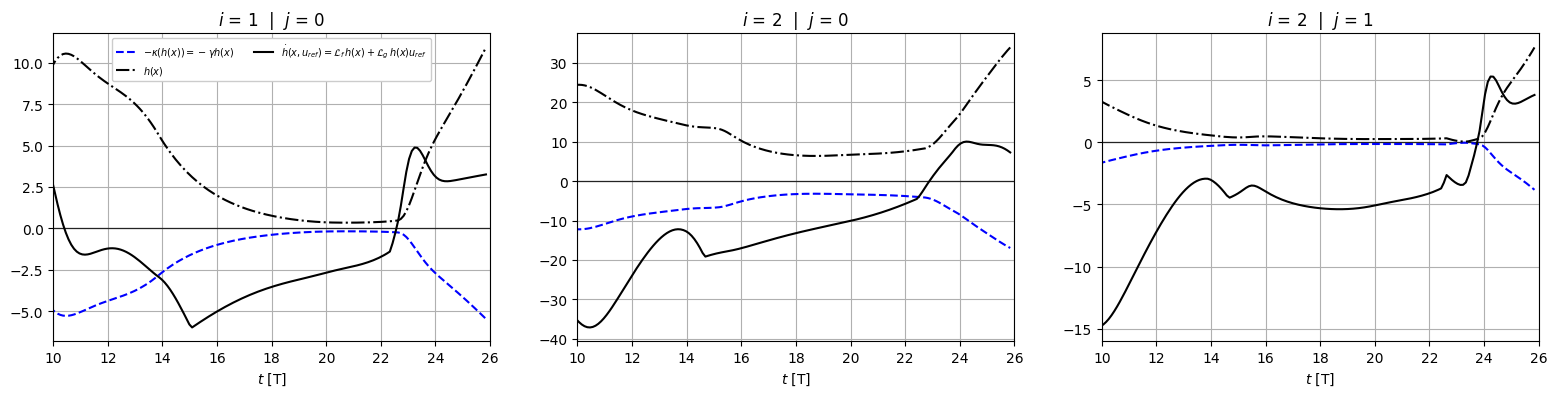

In [ ]:
n_rbt, n_obs = 1, 0

def plot_hkappa(ax, timedt, h_dt, h_dot_dt, kappa_dt, li, lf, i, j):
  # Extraemos los datos relevantes
  x_eval = timedt[li:lf]
  h_eval = h_dt[li:lf,j,i]
  kappa_eval = - kappa_dt[li:lf,j,i]
  h_dot_ref = h_dot_dt[li:lf,j,i]

  # Graficamos sobre el eje
  ax.set_title(r"$i$ = {0:d}  |  $j$ = {1:d}".format(i,j))
  ax.axhline(0, c="k", ls="-", lw=0.9, zorder=2, alpha=0.8)

  ax.plot(x_eval, kappa_eval, "--b",
          label=r"$- \kappa(h(x)) = - \gamma h(x)$")
  ax.plot(x_eval, h_eval, "-.k", label=r"$h(x)$")
  ax.plot(x_eval, h_dot_ref, "-k",
          label=r"$\dot h(x,u_{ref}) = \mathcal{L}_f\,h(x) + \mathcal{L}_g\,h(x)u_{ref}$")

# --------------------------------------------
# Rango de evaluación en x
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# --------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (23/1.2, 4), dpi = 100)
grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(grid[:,0])
ax2 = fig.add_subplot(grid[:,1])
ax3 = fig.add_subplot(grid[:,2])

# Configuración de los ejes
ax1.set_xlim([ti,tf])
ax1.set_xlabel(r"$t$ [T]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax2.set_xlim([ti,tf])
ax2.set_xlabel(r"$t$ [T]")
ax2.set_ylabel(r"")
ax2.grid(True)

ax3.set_xlim([ti,tf])
ax3.set_xlabel(r"$t$ [T]")
ax3.set_ylabel(r"")
ax3.grid(True)

# Graficamos
plot_hkappa(ax1, time_vec, hdata, hdotdata, kappa_data, li, lf, 1, 0)
plot_hkappa(ax2, time_vec, hdata, hdotdata, kappa_data, li, lf, 2, 0)
plot_hkappa(ax3, time_vec, hdata, hdotdata, kappa_data, li, lf, 2, 1)

# Guardamos la figura y visualizamos
ax1.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1, fontsize=7)

plt.savefig(os.path.join(FOLDER_OUTPUT, 'CBF_sim_2.png'))
plt.show()

## ANIMACIÓN: Simulación GVF + CBF

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 50

# Constantes de los controladores
ke = 4
kn = 2

r = 1
gamma = 2

# Estado inicial de los agentes y número de agentes
n_agents = 4
p0 = np.array([[2, 2], [-2, 2], [3, -3], [2, -2]])
v0 =  np.array([[1.5,2.3,1,1]]).T
phi0 = np.pi - np.array([-3*np.pi/4, -np.pi/4, np.pi/4, 3*np.pi/4])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = simulator(gvf_traj, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []

omega_safe_data = []
edata = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    omega_safe_data.append(sim.omega_safe)
    edata.append(sim.e)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

omega_safe_data = np.array(omega_safe_data)
edata = np.array(edata)

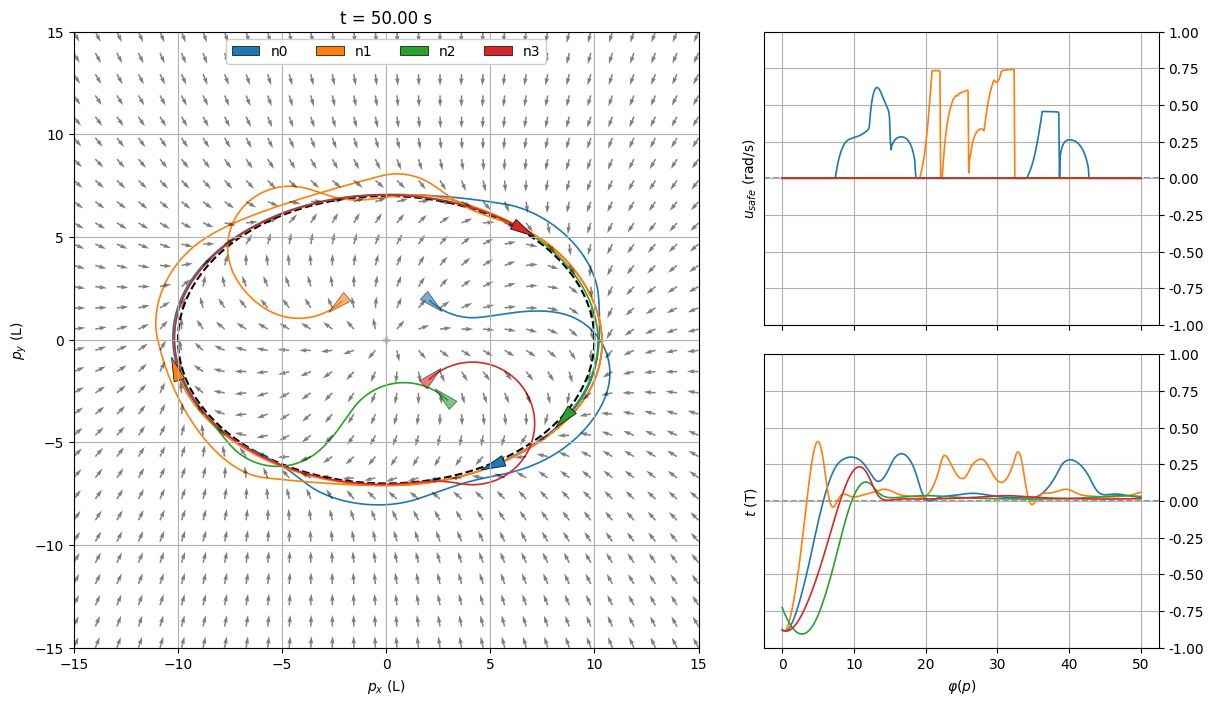

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(14, 8)
dpi=100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
wsafedata_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
edata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, ylabel = r"$u_{safe}$ (rad/s)", ylim=[-1,1])
fmt_data_axis(edata_ax, r"$t$ (T)", r"$\varphi(p)$", ylim=[-1,1])

# Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon.set_label("n"+str(n))

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)

# Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], c=color_palette()[n], lw=1.2)
  edata_ax.plot(time_vec, edata[:,n], c=color_palette()[n], lw=1.2)

plt.show()

In [ ]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail = 250
figsize=(14, 8)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
wsafedata_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
edata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, ylabel = r"$u_{safe}$ (rad/s)", ylim=[-1,1])
fmt_data_axis(edata_ax, r"$t$ (T)", r"$\varphi(p)$", ylim=[-1,1])

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init.set_alpha(0.6)
  icon_init.set_label("n"+str(n))


  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[n],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title("")

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

data_lines_plt = []
for n in range(sim.N):
  kw = dict(c=c_palet[n], lw=1.2)
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], **kw)
  edata_ax.plot(time_vec, edata[:,n], **kw)

wline = wsafedata_ax.axvline(0, c="black", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[n])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  # Actualizamos el título
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s'.format(i, i*dt))

  wline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=20)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  4.90 | 9.84%
tf =  9.80 | 19.68%
tf = 14.70 | 29.52%
tf = 19.60 | 39.36%
tf = 24.50 | 49.20%
tf = 29.40 | 59.04%
tf = 34.30 | 68.88%
tf = 39.20 | 78.71%
tf = 44.10 | 88.55%
tf = 49.00 | 98.39%
